In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import joblib
import string

#NLTK
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

#wordcloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#Sickit learn
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import  make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV



[nltk_data] Downloading package stopwords to /Users/jean-
[nltk_data]     baptisteherold/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jean-
[nltk_data]     baptisteherold/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/jean-
[nltk_data]     baptisteherold/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/Users/jean-baptisteherold/opt/anaconda3/envs/Working/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [13]:
test = pd.read_csv('data.txt', sep=',', encoding='MacRoman')


In [14]:
test.reset_index().to_csv('data.csv', index=False)

#### Commentaires

Objectif : 
* Déterminer si la target est positive ou négative (ou + neutre)
* Prédire la note d'un commentaire

Visualisation : 
*   Histogramme
*   Wordcloud
*   Nombre de mots = longueur des commentaires VS RATING : SCATTER PLOT (sans traitement)
*   Nombre de mots = longueur des commentaires VS RATING : HEATMAPCORRELATION (sans traitement)
*   Nombre de mots = boxplot
*   Evolution des commentaires par rapport à l'année ou au mois/année?
*   Visualiser les ratings par années et par pays : HISTOGRAMME

Nettoyage:
*   Replace 'missing' par np.nan
*   Verifier les valeurs présentes dans Reviewer_Location
*   Verifier les valeurs dans Year_Month
*   Voir si il faut supprimer les individus avec des valeurs manquantes sur Year_Month et Reviewer_Location

Action sur la variable Reviewer_Text:
*   Tokenerisation de la variable pour voir le nombre de mot dans une review.
*   Suppression des stopwords & ponctuation
*   Bag of words (tous les mots sont mis dans un dataframe et mis en rapport avec le rating)
*   Modèlisation

In [2]:
df = pd.read_csv('https://assets-datascientest.s3-eu-west-1.amazonaws.com/de/total/reviews.csv', delimiter=',')

In [3]:
df.head()

,Rating,Year_Month,Reviewer_Location,Review_Text
0,5,2019-3,United Arab Emirates,"We've been to Disneyland Hongkong and Tokyo, s..."
1,4,2018-6,United Kingdom,I went to Disneyland Paris in April 2018 on Ea...
2,5,2019-4,United Kingdom,"What a fantastic place, the queues were decent..."
3,4,2019-4,Australia,We didn't realise it was school holidays when ...
4,5,missing,France,A Trip to Disney makes you all warm and fuzzy ...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13630 entries, 0 to 13629
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Rating             13630 non-null  int64 
 1   Year_Month         13630 non-null  object
 2   Reviewer_Location  13630 non-null  object
 3   Review_Text        13630 non-null  object
dtypes: int64(1), object(3)
memory usage: 426.1+ KB


#### Check valeurs uniques dans variable Rating

In [5]:
#check df_rating = uniquement des nombres
df['Rating'].unique() #OK

array([5, 4, 2, 3, 1])

#### Remplacement des valeurs 'missing' dans Year_month

In [6]:
#check Year_Month valeurs uniques
df['Year_Month'].unique()

array(['2019-3', '2018-6', '2019-4', 'missing', '2018-12', '2018-5',
       '2019-2', '2019-1', '2018-9', '2018-7', '2018-8', '2018-11',
       '2018-10', '2018-4', '2018-3', '2018-2', '2018-1', '2017-11',
       '2017-10', '2017-3', '2017-9', '2017-8', '2017-12', '2017-7',
       '2017-6', '2017-5', '2017-4', '2017-2', '2016-12', '2017-1',
       '2016-11', '2016-10', '2016-9', '2016-8', '2016-7', '2016-6',
       '2016-5', '2016-4', '2016-3', '2016-2', '2016-1', '2015-12',
       '2015-11', '2015-10', '2015-9', '2015-8', '2015-7', '2015-6',
       '2015-5', '2015-4', '2015-3', '2015-2', '2015-1', '2014-12',
       '2014-11', '2014-10', '2014-9', '2014-8', '2014-7', '2014-6',
       '2014-5', '2014-4', '2014-3', '2014-2', '2014-1', '2013-12',
       '2013-11', '2013-10', '2013-9', '2013-8', '2013-7', '2013-6',
       '2013-5', '2013-4', '2013-3', '2013-2', '2013-1', '2012-12',
       '2012-11', '2012-10', '2012-9', '2012-8', '2012-7', '2012-6',
       '2012-5', '2012-4', '2012-3', '20

On voit que il existe des individus qui ont la valeur 'missing'. On remplace cette valeur par des NaN.

In [7]:
#Nettoyage Year_month
df.loc[df['Year_Month']=='missing', 'Year_Month'] = np.nan

Ok nos valeurs 'missing' ont été remplacées par des NaN.

In [8]:
#check Year_Month valeurs uniques
df['Reviewer_Location'].unique()

array(['United Arab Emirates', 'United Kingdom', 'Australia', 'France',
       'Greece', 'Netherlands', 'Portugal', 'Malta', 'United States',
       'Ireland', 'Saudi Arabia', 'Switzerland', 'Bosnia and Herzegovina',
       'Israel', 'Spain', 'Denmark', 'Canada', 'Sweden', 'India', 'Italy',
       'Romania', 'Ecuador', 'Germany', 'South Africa', 'Peru',
       'North Macedonia', 'Mexico', 'New Zealand', 'Poland', 'Serbia',
       'Thailand', 'Cyprus', 'Finland', 'Turkey', 'Lebanon', 'China',
       'Austria', 'Czechia', 'Hungary', 'Belgium', 'Malaysia', 'Tunisia',
       'Bahrain', 'Kuwait', 'Gibraltar', 'Singapore', 'Mali', 'Jersey',
       'Russia', 'Indonesia', 'Albania', 'Bulgaria', 'Japan', 'Ukraine',
       'Brazil', 'Sri Lanka', 'Iran', 'Nigeria', 'Kenya', 'Egypt',
       'Jordan', 'Antigua and Barbuda', 'Oman', 'Qatar', 'Philippines',
       'Uzbekistan', 'Slovakia', 'Norway', 'Argentina', 'Mauritius',
       'Hong Kong', 'Croatia', 'Azerbaijan', 'Luxembourg', 'Ethiopia',
     

In [9]:
df[df['Reviewer_Location'] == 'missing']

,Rating,Year_Month,Reviewer_Location,Review_Text


OK la variable Reviewer_location ne contient pas de valeurs abérrantes.

## PROCESSING TEXT REVIEW

### LOWER TEXT

In [10]:
df['reviews_modified'] = df['Review_Text'].str.lower()

### RETRAIT PONCTUATION

In [11]:
PUNCT_TO_REMOVE = string.punctuation

def remove_punctuation(text):
    """Fonction pour retirer la ponctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

df['reviews_modified'] = df['reviews_modified'].apply(lambda text : remove_punctuation(text))    

### LEMMATISATION

In [12]:
# TOKENIZATION
def lemmatize_text(text):
    """Fonction pour lemmatiser le texte"""
    return [WordNetLemmatizer().lemmatize(e) for e in WhitespaceTokenizer().tokenize(text)]

df['reviews_modified'] = df['reviews_modified'].apply(lemmatize_text)
df['reviews_modified'] = df['reviews_modified'].apply(lambda x : " ".join(x))

### CALCUL NOMBRE DE MOTS

In [13]:
#Création d'une variable contenant le nombre de mots de cette nouvelle variable afin d'obtenir la longueur du commentaire brut.
df['nb_mots'] = df['Review_Text'].str.split(" ").str.len()

In [14]:
#visualisation du nombre de mots moyens par rating
df.groupby('Rating').mean().reset_index()

,Rating,nb_mots
0,1,219.497585
1,2,224.884100
2,3,203.155545
3,4,182.966049
4,5,140.642612


On constate que plus le rating est elevé moins la reviews est longue.

In [15]:
### CALCUL PONCTUATION
df['count_punct'] = df["Review_Text"].apply(lambda s: sum([1 for x in s if x in '?!']))

## DATA EXPLORATION

In [16]:
#visualisation du nombre d emots moyens par rating via Barplot
fig = px.bar(df.groupby('Rating').mean().reset_index(), x='Rating', y='nb_mots', width=800, height=400, title='Nombre de mots moyen par ratings')

fig.update_layout(
            title={
            'x':0.5,
            'xanchor': 'center',
        })

fig.show()

In [17]:
#visualisation du nombre de mots par rating via boxplot
fig = px.box(df, x='Rating', y='nb_mots', width=800, height=400, title='Box plot nombre de mots VS rating')

fig.update_layout(
            title={
            'x':0.5,
            'xanchor': 'center',
        })

fig.show()

In [18]:
#check d'une valeur potentiellement abbérante
df.loc[(df['Rating'] == 4) & (df['nb_mots']> 4000)]

,Rating,Year_Month,Reviewer_Location,Review_Text,reviews_modified,nb_mots,count_punct
12997,4,2011-5,United Kingdom,After having visited Disneyland Paris at least...,after having visited disneyland paris at least...,4068,13


Nous constatons qu'il existe des outliers et nous décidons de supprimer l'ensemble des individus ayants un nombre de mots > 2000.

In [19]:
#filtre df sur valeur nb de mots <2000
df_viz = df[df['nb_mots']<2000]

In [20]:
# Nouvelle visuation des boxpliot post traitement.

fig = px.box(df_viz, x='Rating', y='nb_mots', width=800, height=400, title='Box plot nombre de mots VS rating post retraitement')

fig.update_layout(
            title={
            'x':0.5,
            'xanchor': 'center',
        })

fig.show()

In [21]:
#visualisation du nombre d emots moyens par rating via Barplot
fig = px.bar(df.groupby('Rating').mean().reset_index(), x='Rating', y='nb_mots', width=800, height=400, title='Nombre de mots moyen par ratings post retraitement')

fig.update_layout(
            title={
            'x':0.5,
            'xanchor': 'center',
        })

fig.show()

In [22]:
df_viz.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13622 entries, 0 to 13629
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Rating             13622 non-null  int64 
 1   Year_Month         12687 non-null  object
 2   Reviewer_Location  13622 non-null  object
 3   Review_Text        13622 non-null  object
 4   reviews_modified   13622 non-null  object
 5   nb_mots            13622 non-null  int64 
 6   count_punct        13622 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 851.4+ KB


### Nombre de commentaires par pays

In [23]:
df_count_by_country = pd.DataFrame(df['Reviewer_Location'].value_counts()).reset_index()

In [24]:
fig = px.bar(df_count_by_country, x='index', y=['Reviewer_Location'])
fig.show()


On voit que UK est prédominent.

### Modèle classification analyse du sentiement

#### Retraitement des stop words

In [25]:
wc_positive = df[df['Rating']>3]
wc_negative = df[df['Rating']<3]
wc_neutre = df[df['Rating']==3]

In [26]:
fig = px.bar(pd.DataFrame(df['Rating'].value_counts()).reset_index(), x='index', y='Rating', title="Nombre de commentaires par Ratings")
fig.show()



## WORD CLOUD VIZ

#### GoW ON NEGATIVE

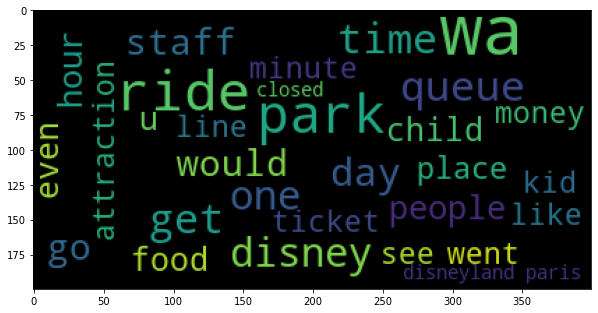

In [27]:
stop_words = set(stopwords.words('english'))

# Start with one review:
text = ''
for e in wc_negative['reviews_modified']:
    text += e

wc = WordCloud(background_color="black", max_words=30, stopwords=stop_words, max_font_size=50, random_state=42)

plt.figure(figsize= (10,6)) # Initialisation d'une figure
wc.generate(text)           # "Calcul" du wordcloud
plt.imshow(wc) # Affichage
plt.show()

### GoW ON POSITIBVE

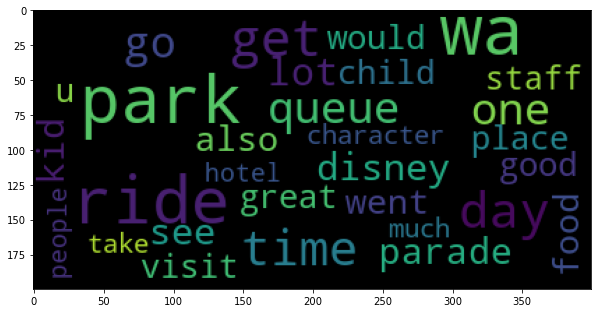

In [28]:
stop_words = set(stopwords.words('english'))

# Start with one review:
text = ''
for e in wc_positive['reviews_modified']:
    text += e

wc = WordCloud(background_color="black", max_words=30, stopwords=stop_words, max_font_size=50, random_state=42)

plt.figure(figsize= (10,6)) # Initialisation d'une figure
wc.generate(text)           # "Calcul" du wordcloud
plt.imshow(wc) # Affichage
plt.show()

### GoW ON NEUTRAL

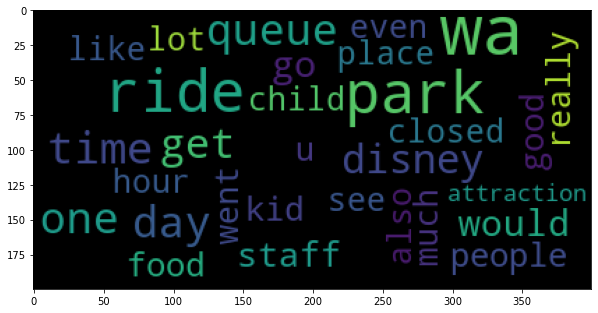

In [29]:
stop_words = set(stopwords.words('english'))

# Start with one review:
text = ''
for e in wc_neutre['reviews_modified']:
    text += e

wc = WordCloud(background_color="black", max_words=30, stopwords=stop_words, max_font_size=50, random_state=42)

plt.figure(figsize= (10,6)) # Initialisation d'une figure
wc.generate(text)           # "Calcul" du wordcloud
plt.imshow(wc) # Affichage
plt.show()

On décide, d'attirbuer le sentiement négatif à la note 3.

In [30]:
df['sentiment'] = 1
df.loc[df['Rating']<4, 'sentiment'] = 0

In [31]:
df[df['Rating']<4]['sentiment'].unique()

array([0])

OK notre variable sentiment est maintenant binaire.

### GoW on whole reviews

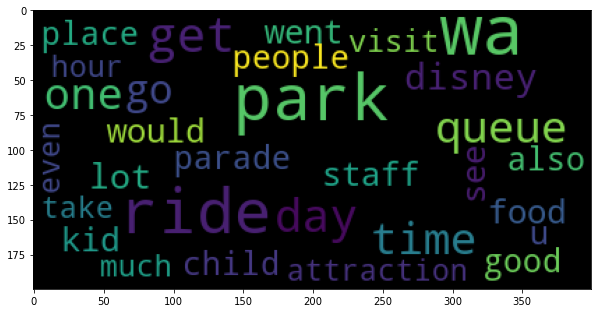

In [32]:
stop_words = set(stopwords.words('english'))

# Start with one review:
text = ''
for e in df['reviews_modified']:
    text += e

wc = WordCloud(background_color="black", max_words=30, stopwords=stop_words, max_font_size=50, random_state=42)

plt.figure(figsize= (10,6)) # Initialisation d'une figure
wc.generate(text)           # "Calcul" du wordcloud
plt.imshow(wc) # Affichage
plt.show()

### MODEL & PIPELINE

In [33]:
#SKLEARN
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
#STRING
import string
#NLTK
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
    

def pipeline(vectorizer, model, df):
    """Fonction pipeline modèle NLP"""

    def calculate_nb_of_words(df, column):
        """Fonction pour calculer le nombre de mots"""
        df['nb_mots'] = df[column].str.split(" ").str.len()
        return df['nb_mots']

    def punct_to_count(df, column, ponctuation_str):
        """Fonction pour calculer le nombre par ponctuation"""
        df['count_punct'] = df[column].apply(lambda s: sum([1 for x in s if x in ponctuation_str]))
        return df['count_punct']

    def remove_punctuation(text):
        """Fonction pour retirer la ponctuation"""
        PUNCT_TO_REMOVE = string.punctuation
        return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

    def lemmatize_text(text):
        """Fonction pour lemmatiser le texte"""
        return [WordNetLemmatizer().lemmatize(e) for e in WhitespaceTokenizer().tokenize(text)]

    def text_tranformation(df, column): 
        """Fonction pour transformer le texte""" 
        df['text_modified']  = df[column].str.lower()
        df['text_modified'] = df['text_modified'].apply(lambda text : remove_punctuation(text))
        df['text_modified'] = df['text_modified'].apply(lemmatize_text)
        df['text_modified'] = df['text_modified'].apply(lambda x : " ".join(x))
        return df['text_modified']

    #Text preprocessing
    df['reviews_modified'] = text_tranformation(df, 'Review_Text')      

    #Calcul nombre de mots
    df['nb_mots'] = calculate_nb_of_words(df, 'reviews_modified')

    df['punct_nb'] = punct_to_count(df, 'Review_Text', '?!')


    if model == 'DecisionTreeClassifier':
        textual_transformer = Pipeline(steps=[('vectorizer', vectorizer)])
        preprocessor = ColumnTransformer(transformers=[("text", textual_transformer, "reviews_modified"),], remainder="passthrough")
        # Ici il faut préciser le nom de ta variable textuelle à transformer à la place de "reviews_modified" si elle est différente
        pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", DecisionTreeClassifier())])
        return pipe

    if model =='LogisticRegression':
        textual_transformer = Pipeline(steps=[('vectorizer', vectorizer)])
        preprocessor = ColumnTransformer(transformers=[("text", textual_transformer, "reviews_modified"), ])
        # Ici il faut préciser le nom de ta variable textuelle à transformer à la place de "reviews_modified" si elle est différente
        pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", LogisticRegression())])
        return pipe

    if model == 'GradientBoostingClassifier':
        textual_transformer = Pipeline(steps=[('vectorizer', vectorizer)])
        preprocessor = ColumnTransformer(transformers=[("text", textual_transformer, "reviews_modified"), ])
        # Ici il faut préciser le nom de ta variable textuelle à transformer à la place de "reviews_modified" si elle est différente
        pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", GradientBoostingClassifier())])
        return pipe




[nltk_data] Downloading package stopwords to /Users/jean-
[nltk_data]     baptisteherold/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jean-
[nltk_data]     baptisteherold/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/jean-
[nltk_data]     baptisteherold/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13630 entries, 0 to 13629
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Rating             13630 non-null  int64 
 1   Year_Month         12694 non-null  object
 2   Reviewer_Location  13630 non-null  object
 3   Review_Text        13630 non-null  object
 4   reviews_modified   13630 non-null  object
 5   nb_mots            13630 non-null  int64 
 6   count_punct        13630 non-null  int64 
 7   sentiment          13630 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 852.0+ KB


In [35]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(df[['reviews_modified', 'nb_mots', 'count_punct']], df['sentiment'], test_size=0.2, shuffle=True)

### LOGISTIC REGRESSION

In [36]:
pipe = pipeline(CountVectorizer(stop_words='english', max_features=10000), 'LogisticRegression', df)
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

/Users/jean-baptisteherold/opt/anaconda3/envs/Working/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [37]:
print(f"L'accuracy score est : {accuracy_score(y_test, y_pred)} et le f1 score est : {f1_score(y_test, y_pred)}")

L'accuracy score est : 0.8477622890682318 et le f1 score est : 0.8936170212765958


In [38]:
confusion_matrix(y_test, y_pred)/len(y_test)*100

array([[20.83639032,  8.62068966],
       [ 6.60308144, 63.93983859]])

In [39]:
tn, fp, fn, tp = (confusion_matrix(y_test, y_pred)/len(y_test)*100).ravel()

In [40]:
import joblib

joblib.dump(pipe, 'LR_pipe.joblib')

['LR_pipe.joblib']

### GRADIENT BOOSTING CLASSIFIER

In [41]:
pipe = pipeline(CountVectorizer(stop_words='english', max_features=10000), 'GradientBoostingClassifier', df)

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

In [42]:
print(f"L'accuracy score est : {accuracy_score(y_test, y_pred)} et le f1 score est : {f1_score(y_test, y_pred)}")

L'accuracy score est : 0.8118121790168745 et le f1 score est : 0.8771845822360547


In [43]:
confusion_matrix(y_test, y_pred)/len(y_test)*100

array([[13.97652238, 15.48055759],
       [ 3.3382245 , 67.20469552]])

In [44]:
tn, fp, fn, tp = (confusion_matrix(y_test, y_pred)/len(y_test)*100).ravel()

### DECISION TREE CLASSIFIER

In [46]:
pipe = pipeline(CountVectorizer(stop_words='english', max_features=10000), 'DecisionTreeClassifier', df)

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

In [47]:
print(f"L'accuracy score est : {accuracy_score(y_test, y_pred)} et le f1 score est : {f1_score(y_test, y_pred)}")

L'accuracy score est : 0.7432134996331622 et le f1 score est : 0.8199588477366255


In [48]:
confusion_matrix(y_test, y_pred)/len(y_test)*100

array([[15.84739545, 13.60968452],
       [12.06896552, 58.47395451]])

In [49]:
tn, fp, fn, tp = (confusion_matrix(y_test, y_pred)/len(y_test)*100).ravel()

### import model test

In [51]:
model = joblib.load('LR_pipe.joblib')

In [52]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('vectorizer',
                                                                   CountVectorizer(max_features=10000,
                                                                                   stop_words='english'))]),
                                                  'reviews_modified')])),
                ('model', LogisticRegression())])

In [54]:
model.predict(X_test)

array([1, 1, 1, ..., 0, 1, 1])

In [55]:
X_test

,reviews_modified,nb_mots,count_punct
7986,me and my wife visited the park the day after ...,173,0
2462,we enjoyed our visit here this week if you man...,184,6
9239,should i really say anything about this place ...,40,2
2856,full of disney spirit the staff are amazing so...,448,7
10317,be prepared to wait up to 60 120 min for a rid...,109,1
...,...,...,...
1027,having been in the area we thought why not giv...,122,0
4518,no word to describe just visit the place to ex...,61,0
11390,we visited disney land paris from the 3rd to t...,163,6
11237,just loved being at the park cannot criticize ...,42,0
